# Feature extraction and segmentation based on activity detection

Here we show how to configure and run MarioDetector, a short-term activity detector, and how to use the result to generate features (here just audio chunks) to feed Tensorflow.

## Import and configure modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import librosa

from nsb_aad.frame_based_detectors.mario_detector import MarioDetector
from phaunos_ml.utils.feature_utils import AudioSegmentExtractor
from phaunos_ml.utils.audio_utils import audio2tfrecord
from phaunos_ml.utils import tf_utils
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

# Get audio data

In [2]:
audiofilename = '/home/jul/data/birdclef2019/train/phaunos/audio_wav_22050hz/amgplo/XC15507.wav'
audio, sr = librosa.load(audiofilename, sr=22050)
print(audio.shape)
print(sr)

(442368,)
22050


# Configure and run segmentation

In [3]:
config_file_mario = '/home/jul/dev/nature_sound_box/nsb_aad/configs/mario.json'
config_mario = json.load(open(config_file_mario, 'r'))

In [4]:
config_mario

{'sample_rate': 22050,
 'win_length': 512,
 'hop_length': 128,
 'min_freq': 200,
 'max_freq': 11025,
 'clipping_threshold': 3,
 'opening_kernel_shape': [2, 3],
 'median_filter_shape': 10}

In [5]:
config_mario['clipping_threshold'] = 8
mario_detector = MarioDetector(config_mario)
mario_detections = mario_detector.process(audio)

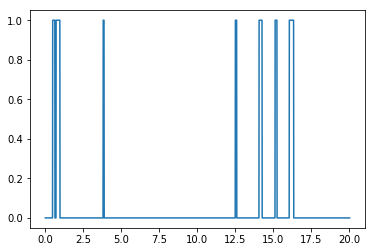

In [6]:
plt.plot(np.arange(len(mario_detections)) / mario_detector.frame_rate, mario_detections)

In [7]:
segment_duration = 1 # in seconds
segment_hop_duration = 1 # in seconds
audio_ex = AudioSegmentExtractor(sr=sr, example_duration=segment_duration, example_hop_duration=segment_hop_duration)

In [8]:
segments, mask_segments, stimes = audio_ex.process(
    audio,
    sr,
    mask=mario_detections,
    mask_sr=mario_detector.frame_rate,
    mask_min_dur=0.05)

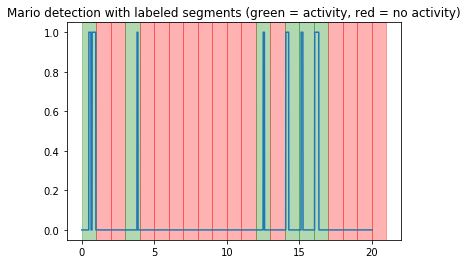

In [9]:
# plot segments (red = 0 = no audio activity detected and green = 1 = audio activity detected)
# on the detection function
fig, ax = plt.subplots()
x_axis = np.arange(len(mario_detections)) / mario_detector.frame_rate
ax.plot(x_axis, mario_detections)
ax.set_title("Mario detection with labeled segments (green = activity, red = no activity)")
for i in range(len(segments)):
    ax.axvspan(
        stimes[i][0],
        stimes[i][1],
        alpha=0.3,
        color='green' if mask_segments[i] else 'red',
        lw=1
    )

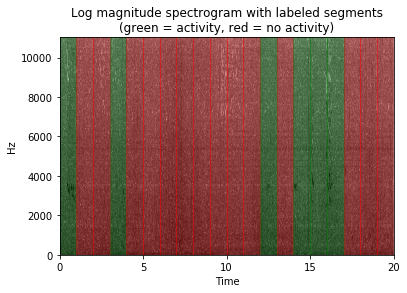

In [10]:
# compute spectrogram
spec_raw = np.abs(librosa.stft(
    audio,
    n_fft=config_mario['win_length'],
    hop_length=config_mario['hop_length'],
    center=False))

# and now plot segments on the spectrogram
plt.figure()
ax = librosa.display.specshow(
    np.log(spec_raw + 1e-6),
    sr=sr,
    hop_length=config_mario['hop_length'],
    cmap='gray_r',
    x_axis='time',
    y_axis='linear')
ax.set_title("Log magnitude spectrogram with labeled segments\n(green = activity, red = no activity)")
for i in range(len(segments)):
    ax.axvspan(
        stimes[i][0],
        stimes[i][1],
        alpha=0.3,
        color='green' if mask_segments[i] else 'red',
        lw=1
    )

# Write audio chunks

audio2tfrecord takes a feature extractor (here an audio chunk extractor) and, optionally, short-term activity detections, and writes features to Tensorflow friendly files (TFRecords) in a *positive* or *negative* directory, depending on the activity detected.

In [11]:
audio2tfrecord(audio,
               sr,
               '/home/jul/data/tfrecords',
               os.path.basename(audiofilename).replace('.wav', '.tf'),
               audio_ex,
               annotation_set=None,
               fb_mask=mario_detections,
               fb_mask_sr=mario_detector.frame_rate,
               mask_min_dur=0.05)

In [12]:
# audio chunks not containing any activity are written to <out_dir>/negative/<filename>.tf
neg = tf_utils.tfrecord2example('/home/jul/data/tfrecords/negative/XC15507.tf', audio_ex)
neg

W0925 17:31:44.381553 140343200204608 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0925 17:31:44.389456 140343200204608 deprecation_wrapper.py:119] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:51: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[{'data': array([[ 0.00378418, -0.00189209,  0.01348877, ...,  0.00564575,
           0.00326538,  0.00216675]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([1.       , 1.9999547], dtype=float32)},
 {'data': array([[ 0.00286865, -0.00030518, -0.00067139, ...,  0.02062988,
           0.01550293,  0.01455688]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([2.       , 2.9999547], dtype=float32)},
 {'data': array([[-0.00735474, -0.00268555, -0.00210571, ..., -0.00970459,
          -0.00372314, -0.00097656]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([4.       , 4.9999547], dtype=float32)},
 {'data': array([[-0.0090332 , -0.01876831, -0.0194397 , ..., -0.02233887,
          -0.01672363, -0.01443481]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([5.       , 5.9999547], dtype=float32)},
 {'data': array([[-0.01690674, -0.0166626 , -0.01220703, ..., -0.004

In [13]:
# audio chunks containing activity are written to <out_dir>/positive/<filename>.tf
pos = tf_utils.tfrecord2example('/home/jul/data/tfrecords/positive/XC15507.tf', audio_ex)

In [14]:
pos

[{'data': array([[0.        , 0.        , 0.        , ..., 0.01312256, 0.01730347,
          0.01980591]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([0.        , 0.99995464], dtype=float32)},
 {'data': array([[ 0.01361084,  0.01373291,  0.01257324, ..., -0.00531006,
          -0.01126099, -0.00872803]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([3.       , 3.9999547], dtype=float32)},
 {'data': array([[ 0.00564575,  0.00292969, -0.00073242, ...,  0.01263428,
           0.00674438, -0.00149536]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([12.      , 12.999954], dtype=float32)},
 {'data': array([[-1.0986328e-03,  3.0517578e-05,  3.6621094e-03, ...,
           9.8266602e-03,  3.3264160e-03, -5.8898926e-03]], dtype=float32),
  'filename': b'XC15507.tf',
  'labels': b'',
  'times': array([14.      , 14.999954], dtype=float32)},
 {'data': array([[-0.00308228,  0.00018311, -0.0009155